# Seq2Seq with Attention Model (Pytorch Version)

## A neural network to translate from French to English

**Examples**: [KEY: > input, = target, < output]<br>

> il est en train de peindre un tableau .<br>
= he is painting a picture .<br>
< he is painting a picture .<br>

> pourquoi ne pas essayer ce vin delicieux ?<br>
= why not try that delicious wine ?<br>
< why not try that delicious wine ?<br>

> elle n est pas poete mais romanciere .<br>
= she is not a poet but a novelist .<br>
< she not not a poet but a novelist .<br>

> vous etes trop maigre .<br>
= you re too skinny .<br>
< you re all alone .<br>

Seq2Seq Paper Link: https://arxiv.org/abs/1409.3215<br>
Attention Mechanism Paper Link: https://arxiv.org/abs/1409.0473

- Two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence. To improve upon this model we’ll use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence.

![](https://i.imgur.com/GVpPU5w.png)

## Requirements

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset

The file is a tab separated list of translation pairs.<br>
Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII.

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

Lowercase, trim, and remove non-letter characters.

In [5]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). 

![](https://i.imgur.com/Xkrm9Km.png)

## Define the word & index transformer

In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Read dataset

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('data/{}-{}.txt'.format(lang1, lang2), encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

## Data Clearning (Sample by eng_prefixes)

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

### ======== CHALLENGE PART ONE ========

Please design your own sampling rules & adjust the model parameters by training with these datasets

### ======== END OF CHALLENGE ONE ========

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs

In [11]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

data_overview_num = 10
for _ in range(data_overview_num):
    print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je suis etourdie .', 'i m forgetful .']
['il ne viendra decidement pas .', 'he s definitely not coming .']
['tu es matinal .', 'you are early .']
['il revasse toujours .', 'he is always day dreaming .']
['il fait de gros progres en anglais .', 'he is making great progress in english .']
['je ne suis pas matinal .', 'i am not a morning person .']
['il est sur de reussir .', 'he is sure of success .']
['je ne suis pas concerne par cette affaire .', 'i am not concerned with this affair .']
['il est au dessus d un tel acte .', 'he is above doing such a thing .']
['je suis juste un autre homme .', 'i m just another man .']


## Seq2Seq Model

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

### Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![](https://i.imgur.com/n340MrD.png)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, inpt, hidden):
        embedded = self.embedding(inpt).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

![](https://i.imgur.com/XITOJbn.png)

### ======== CHALLENGE PART TWO ========

Please build the DecoderRNN without attention refer to the graph above & compare the difference before and after using attention

### ======== END OF CHALLENGE TWO ========

### Attention Decoder

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![](https://i.imgur.com/QIliyjS.png)

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # Transform the double hidden features into probabilities with max_length size
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inpt, hidden, encoder_outputs):
        embedded = self.embedding(inpt).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### ======== CHALLENGE PART THREE ========

Try to use another attention function such as "structure attention" mentioned by https://arxiv.org/pdf/1409.0473.pdf

![](https://i.imgur.com/MIyh9pn.png)

![](https://i.imgur.com/karGLAW.png)
![](https://i.imgur.com/N1HS8n7.png)
![](https://i.imgur.com/bNdw4mD.png)

The dot attention function extracts the **association features between feature vectors by matrix multiplication**, which is more like a machine learning method defined by artificial features. However, structure attention is like a deep learning method to some extent. It automatically learns how to obtain the relevant information between the feature matrices **through hyperparameters W,U and nonlinear equations tanh**. It has a certain improvement on the adaptability of the attention mechanism model.

### ======== END OF CHALLENGE THREE ========

### Training

Prepare the training data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

**A Tip** : “Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability. 

In [15]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0
    
    for en_i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[en_i], encoder_hidden)
        encoder_outputs[en_i] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing mode
        for de_i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[de_i])
            decoder_input = target_tensor[de_i]
            
    else:
        # free running mode
        for de_i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # sample the final timestep output as the current input (argmax function)
            topvalue, topindex = decoder_output.data.topk(1)
            # detach from history as input
            decoder_input = topindex.squeeze().detach()
            
            loss += criterion(decoder_output, target_tensor[de_i])
            if decoder_input.item() == EOS_token:  # item() : to get a Python number from a tensor containing a single value
                break
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Training steps including:
   - Start a timer
   - Initialize optimizers and criterion
   - Create set of training pairs
   - Start empty losses array for plotting

In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total, plot_loss_total = 0, 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Time: {} | ({} | {:.2f}%) avg: {:.4f}".format(timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Start training...

Time: 0m 11s (- 2m 39s) | (200 | 6.67%) avg: 4.1358
Time: 0m 23s (- 2m 30s) | (400 | 13.33%) avg: 3.4383
Time: 0m 35s (- 2m 22s) | (600 | 20.00%) avg: 3.4937
Time: 0m 48s (- 2m 12s) | (800 | 26.67%) avg: 3.5076
Time: 1m 0s (- 2m 0s) | (1000 | 33.33%) avg: 3.3111
Time: 1m 12s (- 1m 48s) | (1200 | 40.00%) avg: 3.2855
Time: 1m 24s (- 1m 37s) | (1400 | 46.67%) avg: 3.1505
Time: 1m 37s (- 1m 25s) | (1600 | 53.33%) avg: 3.0674
Time: 1m 50s (- 1m 13s) | (1800 | 60.00%) avg: 3.0321
Time: 2m 3s (- 1m 1s) | (2000 | 66.67%) avg: 2.9041
Time: 2m 16s (- 0m 49s) | (2200 | 73.33%) avg: 3.0733
Time: 2m 29s (- 0m 37s) | (2400 | 80.00%) avg: 2.9746
Time: 2m 42s (- 0m 24s) | (2600 | 86.67%) avg: 2.8332
Time: 2m 54s (- 0m 12s) | (2800 | 93.33%) avg: 2.8632
Time: 3m 7s (- 0m 0s) | (3000 | 100.00%) avg: 2.7973


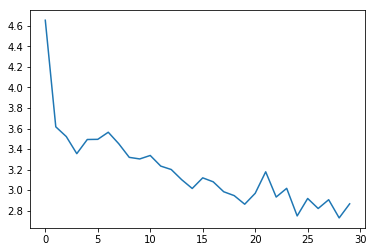

In [21]:
hidden_size = 128
# input is an one-hot vector
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder, attn_decoder, 3000, print_every= 200)

### Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topvalue, topindex = decoder_output.data.topk(1)
            if topindex.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topindex.item()])

            decoder_input = topindex.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(">", pair[0])
        print("=", pair[1])
        output_words, attentions = evaluate(encoder, attn_decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print("<", output_sentence)
        print('\n')

Start evaluating...

In [ ]:
evaluateRandomly(encoder, attn_decoder)

### Data Visualizing

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

In [ ]:
output_words, attentions = evaluate(encoder, attn_decoder, random.choice(pairs)[0])
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

    
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [ ]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

### Using pre-train embedding

- Download pre-trained word-embedding here: 
  - [FastText crawl 300d 2M](https://www.kaggle.com/yekenot/fasttext-crawl-300d-2m)
  - [glove.840B.300d](https://nlp.stanford.edu/projects/glove/)
  - [glove.twitter.27B](https://nlp.stanford.edu/projects/glove/)

In [ ]:
FAST_TEXT_EMBEDDING = 'crawl-300d-2M.vec'

In [ ]:
def load_pretrain_embedding(file):
    """
    Return a dictionary whose key is word, value is pretrained word embedding.
    """
    print('Indexing word vectors')
    embeddings_index = {}
    f = open(file, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        try:
            word = values[0]
            coefs = np.array(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except:
            print("Error on: ", values[:3])
    f.close()
    print("Total %s word vectors" % len(embeddings_index))
    return embeddings_index

In [ ]:
embeddings_index = load_pretrain_embedding(FAST_TEXT_EMBEDDING)

In [ ]:
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300

print('Preparing embedding matrix...')
nb_words = min(MAX_NB_WORDS, output_lang.n_words)
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

null_words = open('null_words.txt', 'w', encoding='utf-8')

for word, idx in output_lang.word2index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        null_words.write(word + '\n')
print('Null_word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) != 0))

In [ ]:
class preAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(preAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # load pre-train embedding
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad=False
        
        # Transform the double hidden features into probabilities with max_length size
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inpt, hidden, encoder_outputs):
        embedded = self.embedding(inpt).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total, plot_loss_total = 0, 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(filter(lambda p: p.requires_grad, decoder.parameters()), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Time: {} | ({} | {:.2f}%) avg: {:.4f}".format(timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
pre_hidden_size = 300

pre_encoder = EncoderRNN(input_lang.n_words, pre_hidden_size).to(device)
pre_attn_decoder = preAttnDecoderRNN(pre_hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(pre_encoder, pre_attn_decoder, 75000, print_every=5000)